# Analyse Clasp acceptability judgements using information value

In [1]:
### Import and utils
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from ast import literal_eval

# For local imports
import sys
sys.path.append('../../')
from utils import load_jsonl, load_surprise_data

# Plots
sns.set_palette('colorblind')
sns.set_style('white', {'font.family': 'Times New Roman'})
sns.set_context("paper", font_scale=2.5)

## Load data and preprocess

In [2]:
DATASETS = ['BLL2018',]#  'brown', 'ns', 'provo']

DATASET_CONTEXT_MAP = {
    'switchboard': 'switchboard/switchboard_results_is.jsonl',
    'dailydialog': 'dailydialog/dailydialog_results_is.jsonl',
    'BLL2018': 'BLL2018/processed_ratings.jsonl',
    'brown': 'RTs/brown_rt.jsonl',
    'ns': 'RTs/ns_rt.jsonl',
    'provo': 'RTs/provo_rt.jsonl',
}

CORPUS_NAMES = {
    'switchboard': 'Switchboard',
    'dailydialog': 'Dailydialog',
    'BLL2018': 'Clasp',
    'provo': 'Provo',
    'brown': 'Brown',
    'ns': 'Natural Stories',
}

MODEL_NAME_MAP = {
    'gpt2': 'GPT-2 Small',
    'gpt2-ft': 'GPT-2 Small Finetuned', # todo: remove
    'gpt2_medium': 'GPT-2 Medium',
    'gpt2-medium': 'GPT-2 Medium',
    'gpt2_large': 'GPT-2 Large',
    'gpt2-large': 'GPT-2 Large',
    'dialogpt_small': 'DialoGPT Small',
    'dialogpt-small': 'DialoGPT Small',
    'dialogpt_medium': 'DialoGPT Medium',
    'dialogpt-medium': 'DialoGPT Medium',
    'dialogpt_large': 'DialoGPT Large',
    'dialogpt-large': 'DialoGPT Large',
    'opt_125m': 'OPT 125M',
    'opt-125m': 'OPT 125M',
    'opt_350m': 'OPT 350M',
    'opt-350m': 'OPT 350M',
    'opt_1.3b': 'OPT 1.3B',
    'opt-1.3b': 'OPT 1.3B',
    'gpt_neo_125m': 'GPT-Neo 125M',
    'gpt-neo-125m': 'GPT-Neo 125M',
    'gpt_neo_1.3b': 'GPT-Neo 1.3B',
    'gpt-neo-1.3b': 'GPT-Neo 1.3B',
    'gpt-neo-1.3B': 'GPT-Neo 1.3B',
}

SAMPLING_PARAM_MAP = {
    "None": "None", "02": "0.2", "03": "0.3", "075": "0.75", "08": "0.8",
    "085": "0.85", "09": "0.9", "095": "0.95", "125": "1.25"
}


In [3]:
### Load data

dfs = []
for dataset in DATASETS:
    print(f"Loading data for {dataset}...")
    DATA_DIR = f"../../../data/surprise/{dataset}"

    df = load_surprise_data(DATA_DIR)

    # Prettify column and value names
    df["corpus"] = df["corpus"].map(CORPUS_NAMES)
    df["sampling"] = df["sampling"].str.capitalize()
    df["sampling"] = df["sampling"].str.replace("Temp", "Temperature")

    df["model"] = df["model"].map(MODEL_NAME_MAP)

    sampling_param_map = {
        "None": "None", "02": "0.2", "03": "0.3", "075": "0.75", "08": "0.8",
        "085": "0.85", "09": "0.9", "095": "0.95", "125": "1.25"
    }
    df["sampling_param"] = df["sampling_param"].map(sampling_param_map)

    dfs.append(df)

surprise = pd.concat(dfs, axis=0, ignore_index=True)

# Set unique data point id for grouping
surprise["item_id"] = surprise.apply(lambda row: f"{row['context_id']}_{row['target_id']}", axis=1)


Loading data for BLL2018...
Size of dataset: 440000 rows


In [4]:
one_df = surprise[
    (surprise['model'] == 'GPT-2 Large') &
    (surprise['corpus'] == 'Clasp') &
    (surprise['sampling'] == 'Nucleus') &
    (surprise['sampling_param'] == '0.95') &
    (surprise['n_samples'] == 100)
]

In [5]:
# One row per judgement
one_df['judgements_in_context'] = one_df['judgements_in_context'].apply(literal_eval)
one_df = one_df.explode('judgements_in_context')
one_df['judgements_in_context'] = pd.to_numeric(one_df['judgements_in_context'])


/tmp/ipykernel_8259/1679081010.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_df['judgements_in_context'] = one_df['judgements_in_context'].apply(literal_eval)


## Statistical models

In [6]:
from statsmodels.formula.api import mixedlm

def get_mixedlm_results(data_df, y, X, group, baseline_rdict=None, nan_policy='fill'):
    """
    Fit a mixed linear model with y as the response variable and X as the predictor variables.
    The model is fit with group as a random effect.

    :param data_df: Dataframe containing estimates and psychometric data
    :param y: Response variable (a string)
    :param X: Predictor variables (a list of strings)
    :param group: Group variable (a string)
    :param baseline_rdict: Dictionary containing results of a baseline model (as returned by this function)
    :param nan_policy: How to handle NaN values in the data. Either 'omit' or 'fill'.
    :return: Tuple containing the model results (a statsmodel object) and a dictionary of results
    """
    if nan_policy == 'omit':
        data_df = data_df.dropna(subset=X)
    elif nan_policy == 'fill':
        data_df = data_df.fillna(1.0)
    else:
        raise ValueError(f"Invalid nan_policy: {nan_policy}")

    formula = f"{y} ~ {' + '.join([x for x in ['1'] + X])}"

    model = mixedlm(
        formula,
        data_df,
        groups=data_df[group]
    )

    result = model.fit(method=["bfgs"])
    result_dict = {}

    tvals = result.tvalues.to_dict()
    for k in tvals:
        if k != "Group Var":
            result_dict[f"Coeff {k}"] = tvals[k]

    pvals = result.pvalues.to_dict()
    for k in pvals:
        if k != "Group Var":
            result_dict[f"p-value {k}"] = pvals[k]

    result_dict["Group Var"] = tvals["Group Var"]
    result_dict["Residual Var"] = result.scale
    result_dict["Total Var"] = result_dict["Residual Var"] + result_dict["Group Var"]
    result_dict["Explained Var"] = result_dict["Group Var"] / result_dict["Total Var"]
    result_dict["Log-Likelihood"] = result.llf
    result_dict["Converged"] = result.converged

    if baseline_rdict:
        result_dict["Delta Log-Likelihood"] = result_dict["Log-Likelihood"] - baseline_rdict["Log-Likelihood"]

    return result, result_dict

In [7]:
def get_single_predictor_results(single_predictor_models):
    # First, get the coefficients, p-values, and deltas.
    coefficients = []
    p_values = []
    deltas = []
    _metrics = []
    for metric in single_predictor_models:
        _metrics.append(metric)
        coefficients.append(single_predictor_models[metric][f'Coeff {metric}'])
        p_values.append(single_predictor_models[metric][f'p-value {metric}'])
        deltas.append(single_predictor_models[metric]['Delta Log-Likelihood'])

    # Then, make a dataframe.
    single_predictor_df = pd.DataFrame({
        'Metric': _metrics,
        'Coefficient': coefficients,
        'Delta Log-Likelihood': deltas,
        'p-value': p_values,
    })

    # Round coefficients and deltas to 3 decimal places.
    single_predictor_df['Coefficient'] = single_predictor_df['Coefficient'].apply(lambda x: round(x, 3))
    single_predictor_df['Delta Log-Likelihood'] = single_predictor_df['Delta Log-Likelihood'].apply(lambda x: round(x, 3))

    # Make a latex table using coefficients, p-values, and deltas. Add a star to coefficient if p-value < 0.001.
    single_predictor_df['Coefficient'] = single_predictor_df.apply(lambda x: f"{x['Coefficient']}{'*' if x['p-value'] < 0.01 else ''}{'*' if x['p-value'] < 0.001 else ''}", axis=1)

    # print table without p-values, rounded to 3 decimal places
    print(single_predictor_df[['Metric', 'Coefficient', 'Delta Log-Likelihood']].to_latex(index=False, float_format="%.3f"))

    return single_predictor_df


In [8]:
def plot_single_predictor_results(single_predictor_df):
    fig, ax = plt.subplots(figsize=(13, 5))
    sns.barplot(
        data=pd.DataFrame({
            "Metric": single_predictor_df['Metric'],
            "Delta Log-Likelihood": single_predictor_df['Delta Log-Likelihood']
        }),
        x="Metric",
        y="Delta Log-Likelihood",
        ax=ax
    )

    ax.set_xlabel("")
    ax.set_ylabel("$\Delta$ Log-Likelihood")
    # rotate x tick labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

In [9]:
all_single_predictors = [
    'surprise_mean_1gram', 'surprise_mean_2gram', 'surprise_mean_3gram',
    'surprise_mean_1gram_pos', 'surprise_mean_2gram_pos', 'surprise_mean_3gram_pos',
    'surprise_mean_cosine', 'surprise_mean_euclidean',
    'surprise_min_1gram', 'surprise_min_2gram', 'surprise_min_3gram',
    'surprise_min_1gram_pos', 'surprise_min_2gram_pos', 'surprise_min_3gram_pos',
    'surprise_min_cosine', 'surprise_min_euclidean',
    'surprise_ooc_mean_1gram', 'surprise_ooc_mean_2gram', 'surprise_ooc_mean_3gram',
    'surprise_ooc_mean_1gram_pos', 'surprise_ooc_mean_2gram_pos', 'surprise_ooc_mean_3gram_pos',
    'surprise_ooc_mean_cosine', 'surprise_ooc_mean_euclidean',
    'surprise_ooc_min_1gram', 'surprise_ooc_min_2gram', 'surprise_ooc_min_3gram',
    'surprise_ooc_min_1gram_pos', 'surprise_ooc_min_2gram_pos', 'surprise_ooc_min_3gram_pos',
    'surprise_ooc_min_cosine', 'surprise_ooc_min_euclidean'
]


-----

## Clasp

### Baseline model

In [10]:
baseline_result, baseline_rdict = get_mixedlm_results(
    one_df,
    y='judgements_in_context',
    X=[],
    group='item_id'
)
print(baseline_result.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: judgements_in_context
No. Observations: 7969    Method:             REML                 
No. Groups:       500     Scale:              0.5756               
Min. group size:  12      Log-Likelihood:     -9749.0657           
Max. group size:  19      Converged:          Yes                  
Mean group size:  15.9                                             
----------------------------------------------------------------------
              Coef.    Std.Err.      z       P>|z|    [0.025    0.975]
----------------------------------------------------------------------
Intercept     2.804       0.031    91.558    0.000     2.744     2.864
Group Var     0.433       0.040                                       



### Single predictor models

In [11]:
single_predictor_models = {}
for metric in tqdm(all_single_predictors):
    _, tmp_mean_surprise_rdict = get_mixedlm_results(
        one_df,
        y='judgements_in_context',
        X=[metric],
        group='item_id',
        baseline_rdict=baseline_rdict
    )
    single_predictor_models[metric] = tmp_mean_surprise_rdict


  0%|          | 0/32 [00:00<?, ?it/s]

In [12]:
single_predictor_df = get_single_predictor_results(single_predictor_models)

\begin{tabular}{llr}
\toprule
Metric & Coefficient & Delta Log-Likelihood \\
\midrule
surprise_mean_1gram & 0.594 & 0.206 \\
surprise_mean_2gram & -1.573 & 2.717 \\
surprise_mean_3gram & -2.514 & 5.857 \\
surprise_mean_1gram_pos & 0.914 & 0.106 \\
surprise_mean_2gram_pos & -0.648 & -0.073 \\
surprise_mean_3gram_pos & -2.011 & 2.274 \\
surprise_mean_cosine & -1.235 & 0.030 \\
surprise_mean_euclidean & -1.535 & 0.617 \\
surprise_min_1gram & -0.867 & 0.005 \\
surprise_min_2gram & -1.937 & 1.639 \\
surprise_min_3gram & -2.757* & 3.714 \\
surprise_min_1gram_pos & -2.931* & 4.915 \\
surprise_min_2gram_pos & -5.356** & 13.539 \\
surprise_min_3gram_pos & -3.104* & 4.124 \\
surprise_min_cosine & -1.982 & 0.979 \\
surprise_min_euclidean & -2.501 & 2.094 \\
surprise_ooc_mean_1gram & 0.356 & 1.241 \\
surprise_ooc_mean_2gram & 0.552 & 3.514 \\
surprise_ooc_mean_3gram & 1.636 & 7.340 \\
surprise_ooc_mean_1gram_pos & -1.649 & 1.520 \\
surprise_ooc_mean_2gram_pos & -0.228 & 0.416 \\
surprise_ooc_mean_

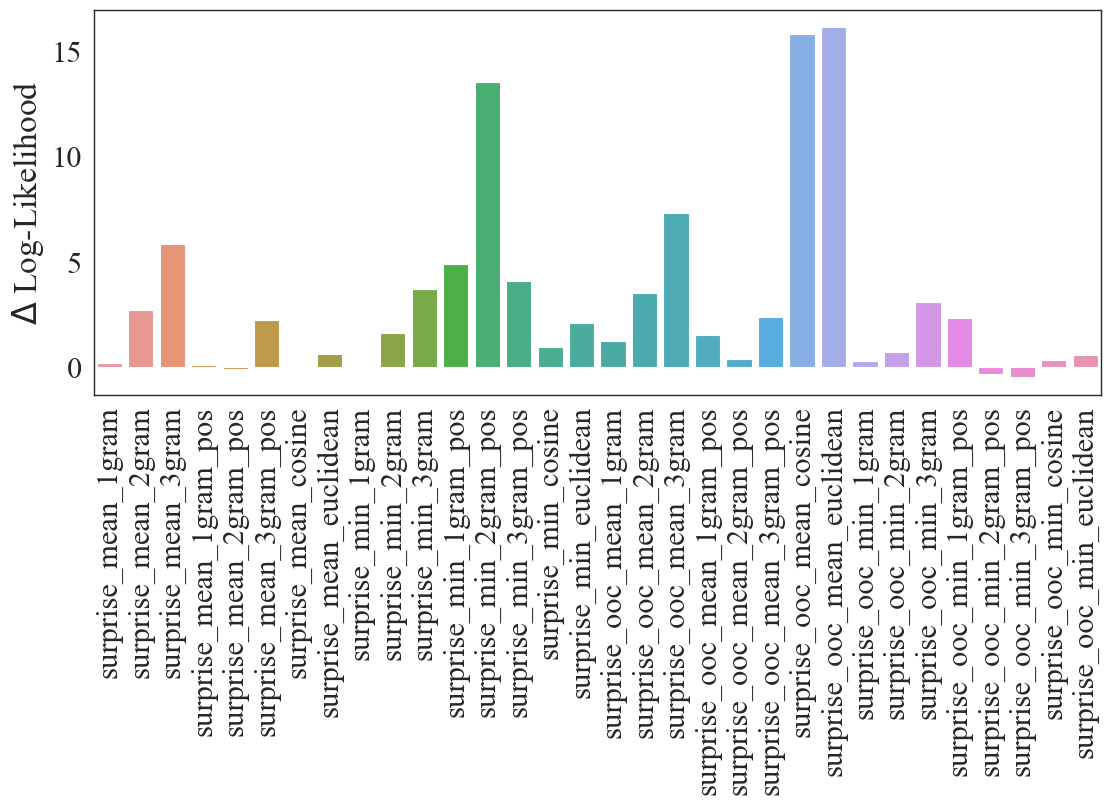

In [13]:
plot_single_predictor_results(single_predictor_df)

### Aggregate predictor models

In [19]:
# Pick the best features in and out of context
metric_dll_df = single_predictor_df[['Metric', 'Delta Log-Likelihood']]

CONTEXT_CONDS = ['In context', 'Out of context']
FEATURES = ['Syntactic', 'Lexical', 'Semantic']

def feature_type(x):
    if 'pos' in x:
        return FEATURES[0]
    elif 'gram' in x:
        return FEATURES[1]
    else:
        return FEATURES[2]

metric_dll_df['Context Condition'] = metric_dll_df['Metric'].apply(lambda x : CONTEXT_CONDS[1] if 'ooc' in x else CONTEXT_CONDS[0])
metric_dll_df['Feature Type'] = metric_dll_df['Metric'].apply(lambda x : feature_type(x))

best_preds = {c: {} for c in CONTEXT_CONDS}
for cond in CONTEXT_CONDS:
    for feat in FEATURES:
        df = metric_dll_df[(metric_dll_df['Context Condition'] == cond) & (metric_dll_df['Feature Type'] == feat)]
        best_preds[cond][feat] = list(df[df['Delta Log-Likelihood'] == df['Delta Log-Likelihood'].max()]['Metric'])[0]

display(best_preds)


/tmp/ipykernel_8259/2127762814.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metric_dll_df['Context Condition'] = metric_dll_df['Metric'].apply(lambda x : CONTEXT_CONDS[1] if 'ooc' in x else CONTEXT_CONDS[0])


{'In context': {'Syntactic': 'surprise_min_2gram_pos',
  'Lexical': 'surprise_mean_3gram',
  'Semantic': 'surprise_min_euclidean'},
 'Out of context': {'Syntactic': 'surprise_ooc_mean_3gram_pos',
  'Lexical': 'surprise_ooc_mean_3gram',
  'Semantic': 'surprise_ooc_mean_euclidean'}}

In [20]:
# Take the best features directly from the best primary features for [for SURPRISE, OOC_SURPRISE, EXPECTED_SURPRISE, DEVIATION_SURPRISE, CONTEXT_INFO]
measures = {
    'mean_surprise': ['surprise_mean_3gram', 'surprise_mean_3gram_pos', 'surprise_mean_cosine'],
    'min_surprise': ['surprise_min_1gram', 'surprise_min_3gram_pos', 'surprise_min_cosine'],
    'ooc_mean_surprise': ['surprise_ooc_mean_1gram', 'surprise_ooc_mean_3gram_pos', 'surprise_ooc_mean_euclidean'],
    'ooc_min_surprise': ['surprise_ooc_min_1gram', 'surprise_ooc_min_3gram_pos', 'surprise_ooc_min_cosine'],
#     'expected_surprise': ['expected_surprise_3gram', 'expected_surprise_3gram_pos', 'expected_surprise_cosine'],
#     'deviation_surprise': ['surprise_deviation_3gram', 'surprise_deviation_3gram_pos', 'surprise_deviation_cosine'],
#     'context_informativeness': ['context_informativeness_3gram', 'context_informativeness_3gram_pos', 'context_informativeness_cosine'],
    'surprise' : [v for k,v in best_preds['In context'].items()],
    'ooc_surprise' : [v for k,v in best_preds['Out of context'].items()],
    'expected_surprise': ['expected_surprise_'+'_'.join(v.split('_')[2:]) for k,v in best_preds['In context'].items()],
    'deviation_surprise': ['surprise_deviation_'+'_'.join(v.split('_')[2:]) for k,v in best_preds['In context'].items()],
    'context_informativeness': ['context_informativeness_'+'_'.join(v.split('_')[2:]) for k,v in best_preds['In context'].items()],
}

measures_dicts = {}
for m, Xs in measures.items():
    print(m, Xs)
    try:
        _, rdict = get_mixedlm_results(
            one_df,
            y='judgements_in_context',
            X=Xs,
            group='item_id',
            baseline_rdict=baseline_rdict
        )
        measures_dicts[m] = rdict
    except:
        print('Error:')
        pass
    
    
# Convert to a dataframe for plotting
measures_df = pd.DataFrame.from_dict(measures_dicts).T
measures_df['Measure'] = measures_df.index
measures_df = measures_df.reset_index(drop=True)
measures_df[['Measure', 'Delta Log-Likelihood']]
measures_df['Distances'] = measures_df['Measure'].apply(lambda x: measures[x])


mean_surprise ['surprise_mean_3gram', 'surprise_mean_3gram_pos', 'surprise_mean_cosine']
min_surprise ['surprise_min_1gram', 'surprise_min_3gram_pos', 'surprise_min_cosine']
ooc_mean_surprise ['surprise_ooc_mean_1gram', 'surprise_ooc_mean_3gram_pos', 'surprise_ooc_mean_euclidean']
ooc_min_surprise ['surprise_ooc_min_1gram', 'surprise_ooc_min_3gram_pos', 'surprise_ooc_min_cosine']
surprise ['surprise_min_2gram_pos', 'surprise_mean_3gram', 'surprise_min_euclidean']
ooc_surprise ['surprise_ooc_mean_3gram_pos', 'surprise_ooc_mean_3gram', 'surprise_ooc_mean_euclidean']
expected_surprise ['expected_surprise_2gram_pos', 'expected_surprise_3gram', 'expected_surprise_euclidean']
deviation_surprise ['surprise_deviation_2gram_pos', 'surprise_deviation_3gram', 'surprise_deviation_euclidean']
context_informativeness ['context_informativeness_2gram_pos', 'context_informativeness_3gram', 'context_informativeness_euclidean']


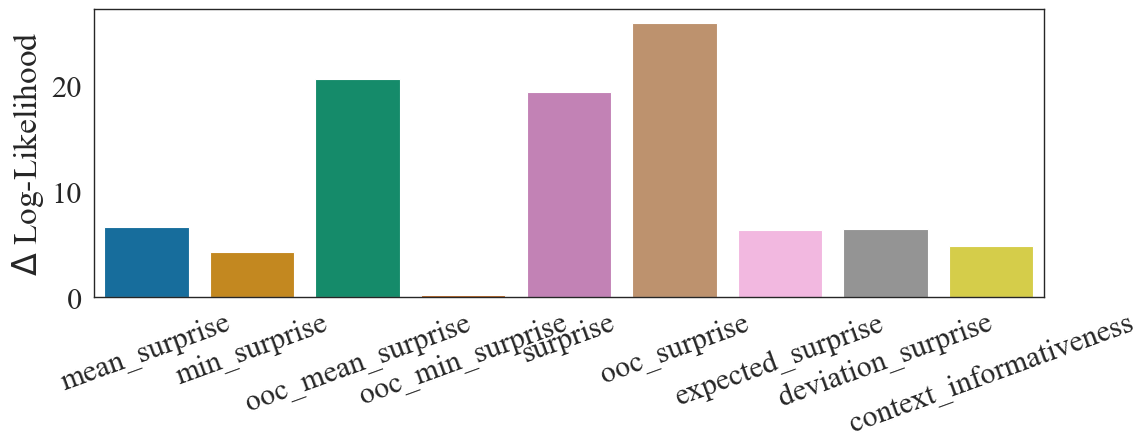

In [21]:
# Plot
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(
    data = measures_df,
    x="Measure",
    y="Delta Log-Likelihood",
    ax=ax
)
ax.set_xlabel("")
ax.set_ylabel("$\Delta$ Log-Likelihood")
# rotate x tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(20)

plt.tight_layout()


In [22]:
# Save results
measures_df.to_csv('dataframes/clasp_measures.csv')


In [23]:
measures_df

,Coeff Intercept,Coeff surprise_mean_3gram,Coeff surprise_mean_3gram_pos,Coeff surprise_mean_cosine,p-value Intercept,p-value surprise_mean_3gram,p-value surprise_mean_3gram_pos,p-value surprise_mean_cosine,Group Var,Residual Var,...,p-value surprise_deviation_3gram,p-value surprise_deviation_euclidean,Coeff context_informativeness_2gram_pos,Coeff context_informativeness_3gram,Coeff context_informativeness_euclidean,p-value context_informativeness_2gram_pos,p-value context_informativeness_3gram,p-value context_informativeness_euclidean,Measure,Distances
0,2.657943,-2.072235,-1.361996,0.276002,0.007862,0.038244,0.173199,0.782546,14.048734,0.57563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mean_surprise,"[surprise_mean_3gram, surprise_mean_3gram_pos,..."
1,17.795153,NaN,NaN,NaN,0.0,NaN,NaN,NaN,14.036105,0.575638,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,min_surprise,"[surprise_min_1gram, surprise_min_3gram_pos, s..."
2,-3.592348,NaN,NaN,NaN,0.000328,NaN,NaN,NaN,13.990021,0.575627,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ooc_mean_surprise,"[surprise_ooc_mean_1gram, surprise_ooc_mean_3g..."
3,5.58206,NaN,NaN,NaN,0.0,NaN,NaN,NaN,14.065637,0.57563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ooc_min_surprise,"[surprise_ooc_min_1gram, surprise_ooc_min_3gra..."
4,1.892656,-1.309666,NaN,NaN,0.058404,0.190309,NaN,NaN,13.978226,0.575636,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,surprise,"[surprise_min_2gram_pos, surprise_mean_3gram, ..."
5,-1.530397,NaN,NaN,NaN,0.125919,NaN,NaN,NaN,13.985837,0.575629,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ooc_surprise,"[surprise_ooc_mean_3gram_pos, surprise_ooc_mea..."
6,3.347089,NaN,NaN,NaN,0.000817,NaN,NaN,NaN,14.039738,0.575631,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,expected_surprise,"[expected_surprise_2gram_pos, expected_surpris..."
7,48.454155,NaN,NaN,NaN,0.0,NaN,NaN,NaN,14.031416,0.575637,...,0.004958,0.078935,NaN,NaN,NaN,NaN,NaN,NaN,deviation_surprise,"[surprise_deviation_2gram_pos, surprise_deviat..."
8,49.416543,NaN,NaN,NaN,0.0,NaN,NaN,NaN,14.043985,0.575635,...,NaN,NaN,-0.954843,-1.884011,2.199586,0.339657,0.059564,0.027836,context_informativeness,"[context_informativeness_2gram_pos, context_in..."
